# Homework 1

Due by March 19

## Data Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
training_path = 'cs-training.csv'
df_train = pd.read_csv(training_path)
df_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
# Fill NaN with columns means
# No need for axis = 0, because it is set by default
df_train.fillna(value = df_train.mean(), inplace = True)

In [4]:
# Extract dataframe as arrays
# 'Unnamed: 0' is index and 'SeriousDlqin2yrs' is classification variable
X_columns  = df_train.columns.difference(['Unnamed: 0', 'SeriousDlqin2yrs'])
X_train = np.array(df_train[X_columns])
y_train = np.array(df_train['SeriousDlqin2yrs'])

In [5]:
# standardize X
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)

## Feature Finding

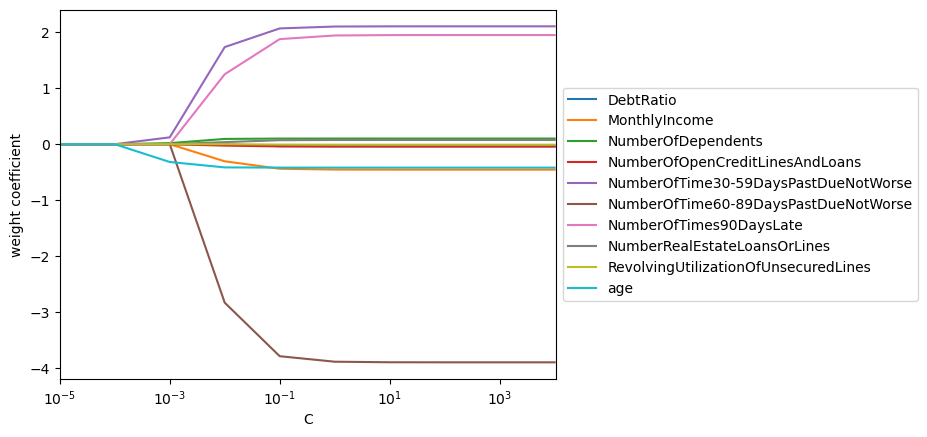

In [7]:
# Estimate weights with different C
weights, params = [], []

for c in np.arange(-5, 5):
    lr = LogisticRegression(C = 10.**c, 
                            random_state = 1,
                            penalty = 'l1', 
                            solver = 'liblinear', # L1 penalty demand liblinear method
                            multi_class = 'ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[0])
    params.append(10.**c)

weights = np.array(weights)

# Plot the trend of weights as C changes
for i in range(weights.shape[1]):
    plt.plot(params, weights[:, i], label=X_columns[i])

plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xlim((10e-6, None))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')

plt.show()

We find that most variables die to 0 in $(10^{-5}, 10^{-2})$, so we focus on this zone.

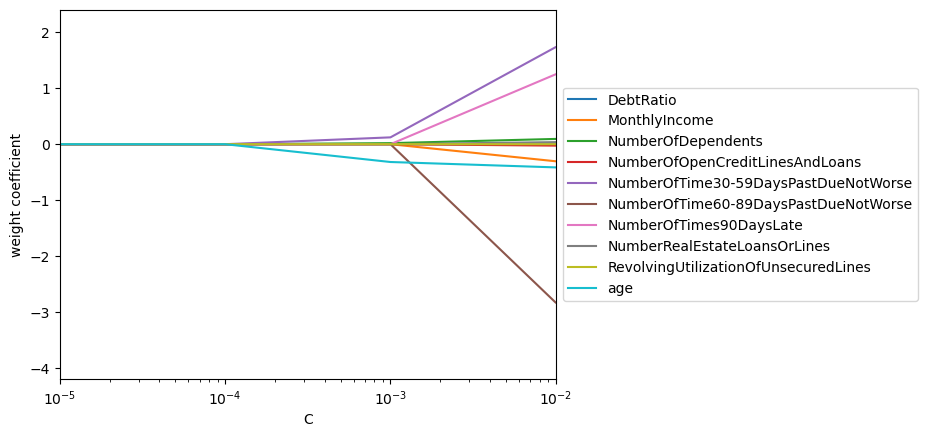

In [8]:
for i in range(weights.shape[1]):
    plt.plot(params, weights[:, i], label=X_columns[i])

plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xlim((10e-6, 10e-3))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')

plt.show()

We can see that all weights are $0$ when $C = 10^{-4}$. And too many weights are not $0$ when $C = 10^{-3}$. So let's try $C = 10^{-3.5}$.

In [9]:
c = -3.5
lr = LogisticRegression(C = 10.**c, 
                        random_state = 1,
                        penalty = 'l1', 
                        solver = 'liblinear',
                        multi_class = 'ovr')
lr.fit(X_train_std, y_train)

coef = lr.coef_[0]
print('There are {} non-zero features when C = 10e{}'.format((coef!=0).sum(), c))

There are 2 non-zero features when C = 10e-3.5


In [10]:
# Extract the column names
feature_column = X_columns[coef.nonzero()]
X_train_2 = np.array(df_train[feature_column])
print('The selected features are: ', feature_column.to_list())

sc = StandardScaler()
sc.fit(X_train_2)
X_train_2_std = sc.transform(X_train_2)

The selected features are:  ['NumberOfTime30-59DaysPastDueNotWorse', 'age']


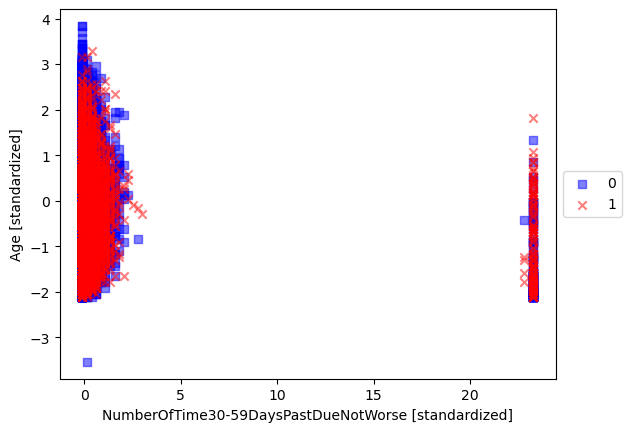

In [11]:
plt.scatter(X_train_2_std[y_train == 0, 0], 
            X_train_2_std[y_train == 0, 1],
            c='b', 
            marker='s',
            alpha=0.5,
            label='0'
            )
plt.scatter(X_train_2_std[y_train == 1, 0], 
            X_train_2_std[y_train == 1, 1],
            c='r', 
            marker='x',
            alpha=0.5,
            label='1'
            )
plt.xlabel('NumberOfTime30-59DaysPastDueNotWorse [standardized]')
plt.ylabel('Age [standardized]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    # I don't know why the following code won't work
    # But I know if I change the colormap parameter there will be no error
    # plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap='RdYlBu')
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')        

## Import Test Set

In [13]:
# import X_test from test set
X_test_path = 'cs-test.csv'
X_df_test = pd.read_csv(X_test_path)
X_test = np.array(X_df_test[feature_column])
# import y_test from the probability set
# for those probability >= 0.5, let y_predict be 1 and otherwise 0
y_test_path = 'sampleEntry.csv'
y_df_test = pd.read_csv(y_test_path)
y_test_p = np.array(y_df_test['Probability'])
benchmark = 0.5
y_test_binary = y_test_p >= benchmark
# Standardize X
sc = StandardScaler()
sc.fit(X_test)
X_test_std = sc.transform(X_test)

## LR

/var/folders/gn/g0b03l8n0fv8zq88xk8mdv0m0000gn/T/ipykernel_58716/1803850316.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


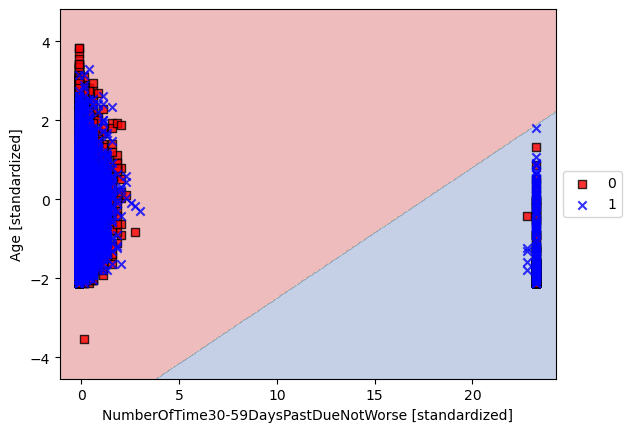

In [14]:
c = 1
lr = LogisticRegression(C = 10.**c, 
                        random_state = 1,
                        # penalty = 'l1', 
                        # solver = 'liblinear',
                        solver = 'lbfgs',
                        multi_class = 'ovr')
lr.fit(X_train_2_std, y_train)

plot_decision_regions(X = X_train_2_std, 
                      y = y_train,
                      classifier = lr)

plt.xlabel('NumberOfTime30-59DaysPastDueNotWorse [standardized]')
plt.ylabel('Age [standardized]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [15]:
for c in np.arange(-5, 5):
    lr = LogisticRegression(C = 10.**c, 
                            random_state = 1,
                            solver = 'lbfgs',
                            multi_class = 'ovr')
    lr.fit(X_train_2_std, y_train)

    accuracy_lr = (lr.predict(X_test_std) == y_test_binary).mean()
    print('The accuracy of logistic regression is {0:.4f} when C = 10e{1}'.format(accuracy_lr, c))

The accuracy of logistic regression is 0.9832 when C = 10e-5
The accuracy of logistic regression is 0.9833 when C = 10e-4
The accuracy of logistic regression is 0.9836 when C = 10e-3
The accuracy of logistic regression is 0.9836 when C = 10e-2
The accuracy of logistic regression is 0.9836 when C = 10e-1
The accuracy of logistic regression is 0.9836 when C = 10e0
The accuracy of logistic regression is 0.9836 when C = 10e1
The accuracy of logistic regression is 0.9836 when C = 10e2
The accuracy of logistic regression is 0.9836 when C = 10e3
The accuracy of logistic regression is 0.9836 when C = 10e4


## SVM

In [16]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1.0, random_state=1)
svm.fit(X_train_2_std, y_train)

accuracy_svm = (svm.predict(X_test_std) == y_test_binary).mean()
print('The accuracy of support vector machine is {0:.4f}'.format(accuracy_svm))

The accuracy of support vector machine is 0.9837


/var/folders/gn/g0b03l8n0fv8zq88xk8mdv0m0000gn/T/ipykernel_58716/1803850316.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
/var/folders/gn/g0b03l8n0fv8zq88xk8mdv0m0000gn/T/ipykernel_58716/1803850316.py:45: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


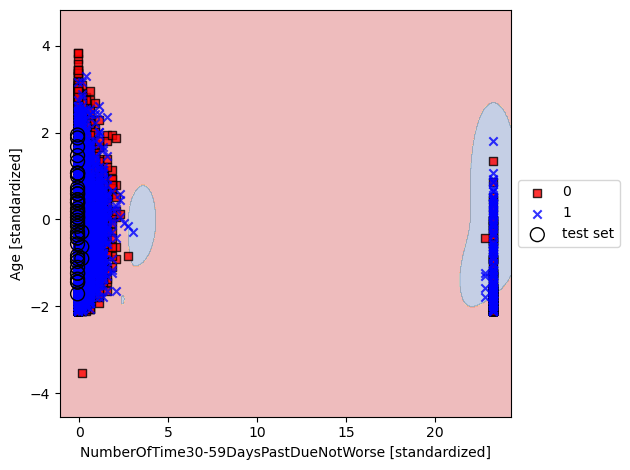

In [17]:
plot_decision_regions(X_train_2_std, 
                      y_train,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('NumberOfTime30-59DaysPastDueNotWorse [standardized]')
plt.ylabel('Age [standardized]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier

for depth in [2, 3, 4, 5]:
    credit_model = DecisionTreeClassifier(criterion='gini', 
                                        max_depth=4, 
                                        random_state=1)
    credit_model.fit(X_train_2, y_train)

    accuracy_dt = (credit_model.predict(X_test_std) == y_test_binary).mean()
    print('The accuracy of decision tree is {0:.4f} when depth is {1}'.format(accuracy_dt, depth))

The accuracy of decision tree is 0.9832 when depth is 2
The accuracy of decision tree is 0.9832 when depth is 3
The accuracy of decision tree is 0.9832 when depth is 4
The accuracy of decision tree is 0.9832 when depth is 5


/var/folders/gn/g0b03l8n0fv8zq88xk8mdv0m0000gn/T/ipykernel_58716/1803850316.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


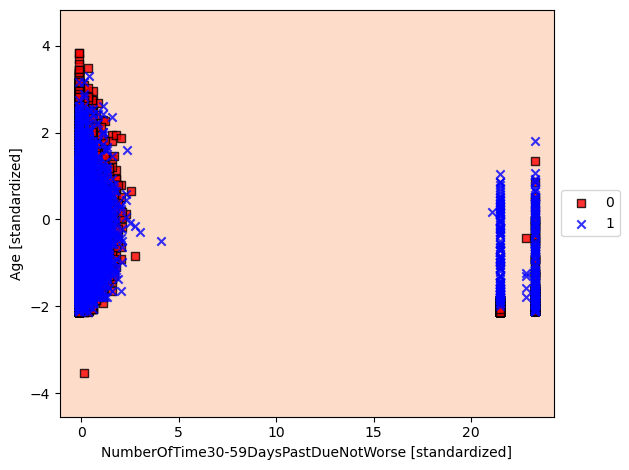

In [22]:
# Plot the decision regions
credit_model = DecisionTreeClassifier(criterion='gini', 
                                        max_depth=3, 
                                        random_state=1)
credit_model.fit(X_train_2, y_train)

X_combined = np.vstack((X_train_2_std, X_test_std))
y_combined = np.hstack((y_train, y_test_binary))
plot_decision_regions(X_combined, y_combined, 
                      classifier = credit_model)

plt.xlabel('NumberOfTime30-59DaysPastDueNotWorse [standardized]')
plt.ylabel('Age [standardized]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Note

It seems very suspicious that all the methods share a very similar accuracy around 0.98. The reason is that our sample is highly biased towards the group 0. See the following output:

In [26]:
print('The mean of y in training set is {:.4f}'.format(y_train.mean()))
print('The mean of y in test set is {:.4f}'.format(y_test_binary.mean()))

The mean of y in training set is 0.0668
The mean of y in test set is 0.0168


As the mean of $y_{train}$ is only $0.067$ (which means over 90% of the samples are in group 0), the algorithms just assume that all samples are 0. Also the proportion of 0 in the test set is around $0.98$, so we get a very stable accuracy of $0.98$.

If we want to solve the problem, the most intuitive way is to use `class_weight = 'balanced'`:

In [29]:
for c in np.arange(-5, 5):
    lr = LogisticRegression(C = 10.**c, 
                            random_state = 1,
                            solver = 'lbfgs',
                            multi_class = 'ovr',
                            class_weight = 'balanced')
    lr.fit(X_train_2_std, y_train)

    accuracy_lr = (lr.predict(X_test_std) == y_test_binary).mean()
    print('The accuracy of logistic regression is {0:.4f} when C = 10e{1}'.format(accuracy_lr, c))

The accuracy of logistic regression is 0.6274 when C = 10e-5
The accuracy of logistic regression is 0.6187 when C = 10e-4
The accuracy of logistic regression is 0.6748 when C = 10e-3
The accuracy of logistic regression is 0.7170 when C = 10e-2
The accuracy of logistic regression is 0.7142 when C = 10e-1
The accuracy of logistic regression is 0.7142 when C = 10e0
The accuracy of logistic regression is 0.7142 when C = 10e1
The accuracy of logistic regression is 0.7142 when C = 10e2
The accuracy of logistic regression is 0.7142 when C = 10e3
The accuracy of logistic regression is 0.7142 when C = 10e4


The results are even worse.